In [100]:
import os
import pandas as pd
import sys


current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.append(project_root)


# Construct absolute path for heuristic_results_folder
# Construct the path to the correct heuristic results folder
heuristic_results_folder = os.path.join(project_root, "Heuristic Results")


In [101]:
duplicate_columns = [
    "Instance ID",
    "use_ml_guidance",
    "use_location_first",
    "use_ML_direct",
    "use_ML_transhipment"
]

def resolve_duplicates(group):
    # Convert "ML_OFV - Total Costs" to numeric, treating invalid values as NaN
    group["ML_OFV - Total Costs"] = pd.to_numeric(group["ML_OFV - Total Costs"], errors="coerce")
    
    # If all "ML_OFV - Total Costs" are NaN, return the first row
    if group["ML_OFV - Total Costs"].isna().all():
        return group.iloc[0]
    
    # Otherwise, return the row with the minimum "ML_OFV - Total Costs", ignoring NaNs
    best_row_index = group["ML_OFV - Total Costs"].idxmin()
    return group.loc[best_row_index]

In [102]:
#Collect all CSV files in the folder
csv_files = [
    os.path.join(heuristic_results_folder, f)
    for f in os.listdir(heuristic_results_folder)
    if f.endswith(".csv")
]

# Combine all CSV files into a single DataFrame
combined_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
print(combined_df.shape)

(127, 11)


In [103]:
# Apply the duplicate resolution function
cleaned_df = (
    combined_df.groupby(duplicate_columns, group_keys=False)
    .apply(resolve_duplicates)
    .reset_index(drop=True)
)

# Save the cleaned DataFrame to a new CSV file
output_file = os.path.join(heuristic_results_folder, "Cleaned_Heuristic_Results.csv")
cleaned_df.to_csv(output_file, index=False)

print(f"Cleaned results saved to: {output_file}")

Cleaned results saved to: /Users/sara/Desktop/Project_OR_Models/ML Experiments/Heuristic Results/Cleaned_Heuristic_Results.csv


/var/folders/0x/srq0vrrs0gl8rlxxj3_45dwc0000gn/T/ipykernel_71735/522150314.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(resolve_duplicates)


In [104]:
# Define a function to calculate the % gap
def calculate_gap(heuristic_ofv, best_known_ofv):
    if pd.isna(heuristic_ofv) or pd.isna(best_known_ofv):
        return "N/A"
    return f"{((heuristic_ofv - best_known_ofv) / best_known_ofv) * 100:.2f}%"

# Define the combinations and their labels
combinations = [
    (False, False, False, False),  # No ML guidance, no location first
    (False, True, False, False),   # No ML guidance, location first
    (True, False, True, True),     # ML-guided (both, no location first)
    (True, False, True, False),    # ML-guided (direct only, no location first)
    (True, False, False, True),    # ML-guided (transshipment only, no location first)
    (True, True, True, False),     # ML-guided (direct only, location first)
    (True, True, False, True),     # ML-guided (transshipment only, location first)
    (True, True, True, True),      # ML-guided (both, location first)
]

labels = [
    "Best Known Solution",
    "Top-Down Heuristic",
    "ML Heuristic",
    "Partial ML Heuristic - Direct only",
    "Partial ML Heuristic - Transshipment only",
    "Top-Down + Partial ML Heuristic - Direct only",
    "Top-Down + Partial ML Heuristic - Transshipment only",
    "Top-Down + Full ML Heuristic",
]

# Initialize the summary table
summary = []

# Group by Instance ID
for instance_id, group in cleaned_df.groupby("Instance ID"):
    # Get the Best Known Solution
    best_known_row = group[
        (group["use_ml_guidance"] == False) &
        (group["use_location_first"] == False) &
        (group["use_ML_direct"] == False) &
        (group["use_ML_transhipment"] == False)
    ]
    
    if best_known_row.empty:
        # If no best known solution, skip this instance
        continue

    best_known_ofv = best_known_row["ML_OFV - Total Costs"].iloc[0]
    optimal = best_known_row["ML_Optimality Gap"].iloc[0] < 0.01
    
    # Initialize the row with the Best Known Solution
    row = {
        "Instance ID": instance_id,
        "Best Known Solution": f"{best_known_ofv:.2f}" + ("*" if optimal else ""),
    }

    # Calculate % gaps for each combination
    for combination, label in zip(combinations, labels):
        if label == "Best Known Solution":
            # Skip recalculating for Best Known Solution
            continue
        
        heuristic_row = group[
            (group["use_ml_guidance"] == combination[0]) &
            (group["use_location_first"] == combination[1]) &
            (group["use_ML_direct"] == combination[2]) &
            (group["use_ML_transhipment"] == combination[3])
        ]

        if heuristic_row.empty:
            row[label] = "N/A"
        else:
            heuristic_ofv = heuristic_row["ML_OFV - Total Costs"].iloc[0]   
                
            row[label] = calculate_gap(heuristic_ofv, best_known_ofv)

    # Add the row to the summary
    summary.append(row)

# Create a DataFrame for the summary
summary_df = pd.DataFrame(summary)


summary_df.to_csv('Summary.csv')


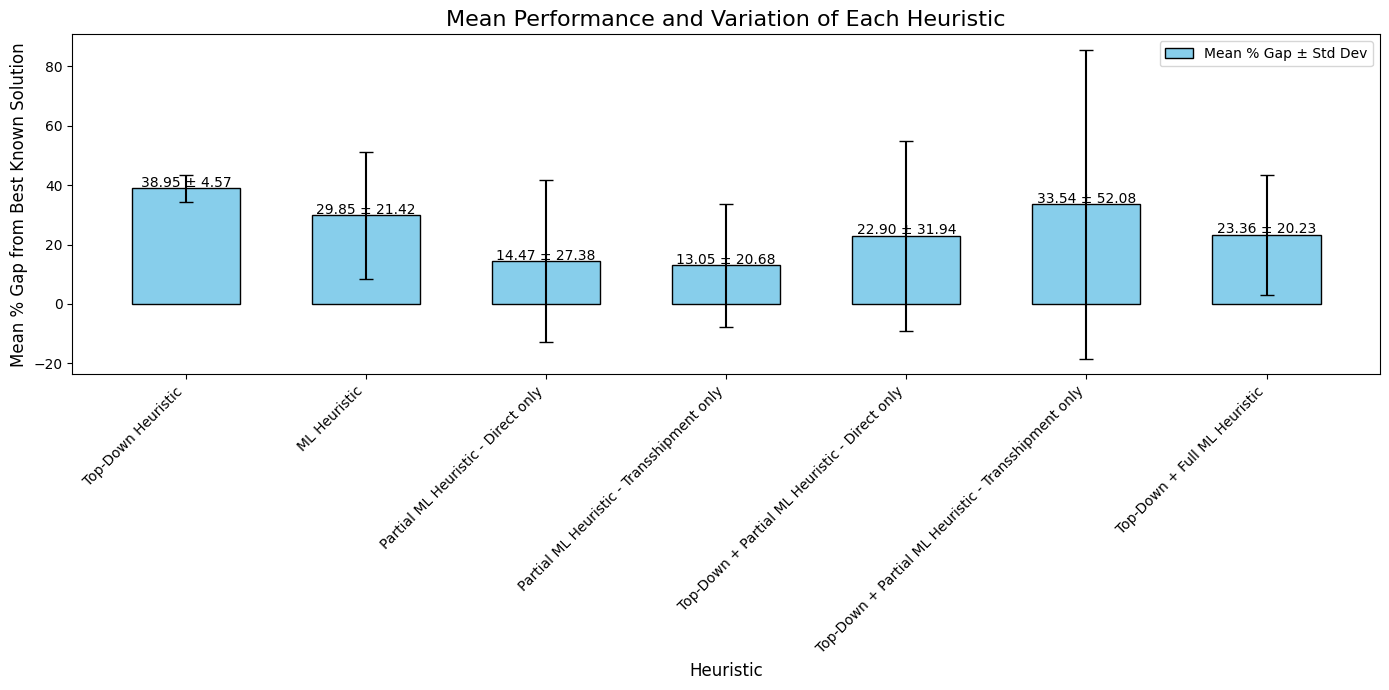

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
heuristic_columns = [
    "Top-Down Heuristic",
    "ML Heuristic",
    "Partial ML Heuristic - Direct only",
    "Partial ML Heuristic - Transshipment only",
    "Top-Down + Partial ML Heuristic - Direct only",
    "Top-Down + Partial ML Heuristic - Transshipment only",
    "Top-Down + Full ML Heuristic",
]

# Convert percentage strings to numeric values, ignoring "N/A"
# Convert percentage strings to numeric values, handling "N/A" and non-string cases
for col in heuristic_columns:
    summary_df[col] = (
        summary_df[col]
        .astype(str)  # Convert all entries to strings
        .str.replace('%', '', regex=False)  # Remove the '%' symbol
        .replace("N/A", None)  # Replace "N/A" with None
        .astype(float)  # Convert to numeric
    )

# Calculate mean and standard deviation for each heuristic
mean_gaps = summary_df[heuristic_columns].mean()
std_gaps = summary_df[heuristic_columns].std()

# Plot configuration
x = np.arange(len(heuristic_columns))  # X-axis positions
width = 0.6  # Width of the bars

# Create the figure and bar chart
plt.figure(figsize=(14, 7))
bars = plt.bar(x, mean_gaps, width, yerr=std_gaps, capsize=5, color="skyblue", edgecolor="black", label="Mean % Gap")

# Add labels and title
plt.ylabel("Mean % Gap from Best Known Solution", fontsize=12)
plt.xlabel("Heuristic", fontsize=12)
plt.title("Mean Performance and Variation of Each Heuristic", fontsize=16)
plt.xticks(x, heuristic_columns, rotation=45, ha="right", fontsize=10)

# Add numerical labels on top of bars
for bar, mean, std in zip(bars, mean_gaps, std_gaps):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{mean:.2f} ± {std:.2f}",
        ha="center",
        fontsize=10
    )

# Legend
plt.legend(["Mean % Gap ± Std Dev"], fontsize=10, loc="upper right")

# Tight layout for better appearance
plt.tight_layout()

# Display the plot
plt.show()


<Figure size 1400x700 with 0 Axes>

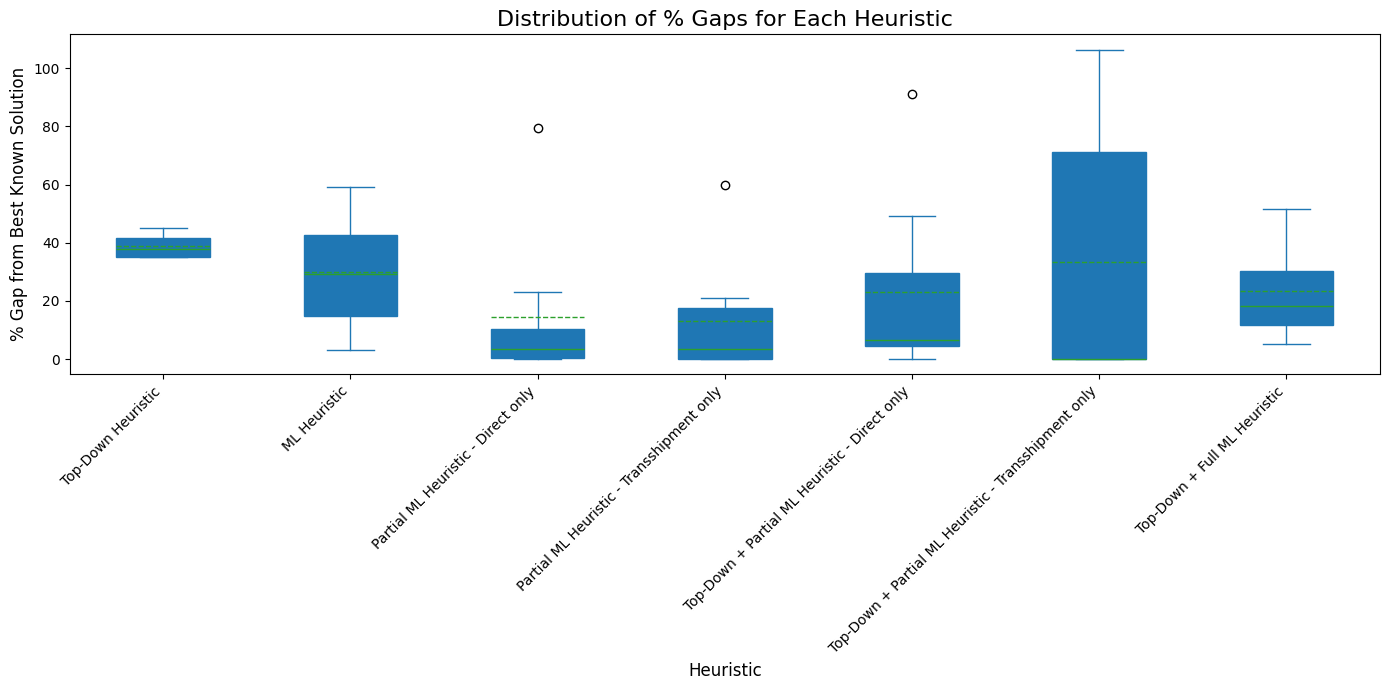

In [106]:
# Prepare data for box plot
box_data = summary_df[heuristic_columns]

# Plot box plot
plt.figure(figsize=(14, 7))
box_data.plot(kind='box', vert=True, grid=False, patch_artist=True, figsize=(14, 7), showmeans=True, meanline=True)

# Add labels and title
plt.title("Distribution of % Gaps for Each Heuristic", fontsize=16)
plt.ylabel("% Gap from Best Known Solution", fontsize=12)
plt.xlabel("Heuristic", fontsize=12)
plt.xticks(range(1, len(heuristic_columns) + 1), heuristic_columns, rotation=45, ha="right", fontsize=10)

plt.tight_layout()
plt.show()


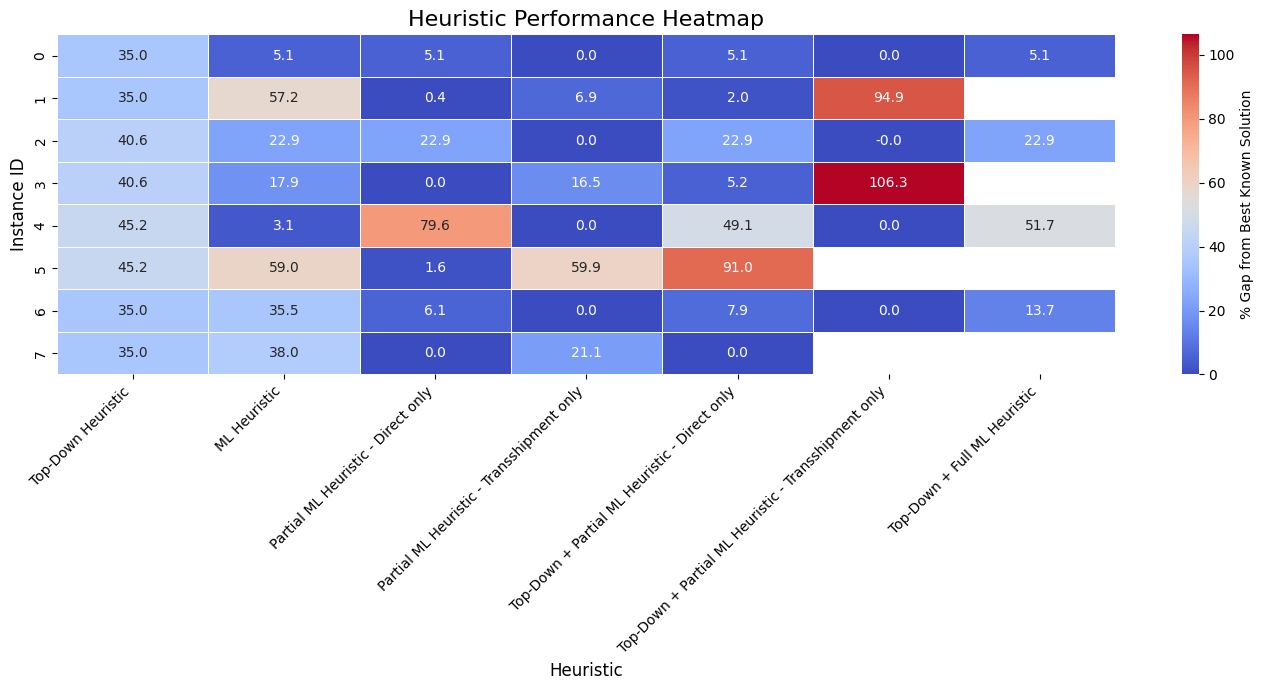

In [107]:
import seaborn as sns

# Prepare data for heatmap
heatmap_data = summary_df[heuristic_columns]

# Plot heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"label": "% Gap from Best Known Solution"}
)

# Add labels and title
plt.title("Heuristic Performance Heatmap", fontsize=16)
plt.xlabel("Heuristic", fontsize=12)
plt.ylabel("Instance ID", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)

plt.tight_layout()
plt.show()
